# 🧭 Overview

This tutorial walks you through generating a synthetic spectrum by manipulating the model parameters.

In [2]:
import os 
import test_module
from collections import namedtuple
import numpy as np
import retrieval_run
import settings
import cloud_dic
import utils
import test_module
import brewtools
import matplotlib.pyplot as plt




## 1. Define All Class Setups:
Instrument, ModelConfig, IOConfig, Retrieval_params, and ArgsGen.

In [3]:
# instrument
fwhm=555
wavelength_range=[1,2.49]
ndata=1
Rfile='./examples/example_data/G570D_R_file.txt'
obspec = np.asfortranarray(np.loadtxt("./examples/example_data/G570D_2MHcalib.dat",dtype='d',unpack='true')) # G570D_2MassJcalib.dat


## gas
chemeq=0
# gaslist = ['h2o','co','tio','vo','crh','feh','na','k']
gaslist = ['h2o','ch4']
gastype_list=['U','U']

# PT structure
ptype=7  

## clouds
cloudpath='/Users/fw23aao/Downloads/cloud_pickles/'
do_clouds=1
npatches=1
cloud_name=['MgSiO3.mieff'] #Mg2SiO4 MgSiO3
cloud_type=["slab"]
particle_dis=["hansen"] #"hansen" "log_normal"
cloudpatch_index=[[1]]


# ModelConfig:
do_fudge=1
samplemode='mcmc'


instrument_instance = utils.Instrument(fwhm=fwhm, wavelength_range=wavelength_range, R_file=Rfile,obspec=obspec)
re_params = utils.Retrieval_params(samplemode,chemeq,gaslist,gastype_list,fwhm,do_fudge,ptype,do_clouds,npatches,cloud_name,cloud_type,cloudpatch_index,particle_dis, instrument_instance)
model_config_instance = utils.ModelConfig(samplemode,do_fudge,cloudpath=cloudpath)
io_config_instance = utils.IOConfig()

model_config_instance.dist= 5.84
model_config_instance.xlist ='data/gaslistRox.dat'
model_config_instance.xpath ='../../Linelists/'
model_config_instance.do_bff=1
model_config_instance.malk=0
model_config_instance.ch4=0
model_config_instance.update_dictionary()

## 2. Generate the Args Instance
Load the opacity data (line lists and cia) and cloud data to prepare for the forward model.

In [4]:
args_instance = utils.ArgsGen(re_params,model_config_instance,instrument_instance,obspec)
settings.init(args_instance)
settings.cia = args_instance.cia
settings.linelist= utils.get_opacities(args_instance.gaslist,args_instance.w1,args_instance.w2,args_instance.press,args_instance.xpath,args_instance.xlist,args_instance.malk)
settings.cloudata = args_instance.cloudata

## 3 check all model parameters

In [6]:
args_instance=settings.runargs
all_params,all_params_values =utils.get_all_parametres(re_params.dictionary)
print(all_params)
print(all_params_values)

['h2o', 'ch4', 'logg', 'r2d2', 'dlambda', 'tolerance_parameter_1', 'Tint', 'alpha', 'lndelta', 'T1', 'T2', 'T3', 'tau_mcs_MgSiO3', 'logp_mcs_MgSiO3', 'dp_mcs_MgSiO3', 'hansen_a_mcs_MgSiO3', 'hansen_b_mcs_MgSiO3']
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


## 4. Initialize the Retrieval Parameters
Here we use the default parameter distributions and create a random initialization.


In [7]:
if re_params.samplemode=='mcmc':
    
    model_config_instance.ndim=len(all_params)
    model_config_instance.nwalkers=len(all_params)*16

    r2d2 = (71492e3)**2. / (model_config_instance.dist * 3.086e+16)**2.
    re_params.dictionary['refinement_params']['params']['r2d2']['distribution']=['normal',r2d2,0.1*r2d2]


    def tolerance_parameter_customized_distribution(x):
        return np.log10((np.random.rand(x)* (max(args_instance.obspec[2,:]**2)*(0.1 - 0.01))) + (0.01*min(args_instance.obspec[2,10::3]**2))) 

    for i in range(len(all_params)):
        if all_params[i].startswith('tolerance_parameter'):
            re_params.dictionary['refinement_params']['params'][all_params[i]]['distribution']=['customized',tolerance_parameter_customized_distribution]

    if model_config_instance.fresh == 0:
        p0=utils.MC_P0_gen(re_params.dictionary,model_config_instance,args_instance)

### 4.1 Create a Parameter Instance 
wrap the initialized values into a convenient namedtuple structure for use with the forward model.

In [8]:
params_master = namedtuple('params',all_params)
params_instance = params_master(*p0[0,:])
params_instance

params(h2o=-3.6109323106503948, ch4=-3.8757280498244406, logg=4.60601175254986, r2d2=1.5684236295743142e-19, dlambda=0.0004955097584481607, tolerance_parameter_1=-32.45255363396046, Tint=1325.6812908463153, alpha=1.60894617615406, lndelta=0.11917961913824066, T1=1014.5134809556599, T2=1301.7397098808115, T3=1358.0889618242106, tau_mcs_MgSiO3=10.981067298377152, logp_mcs_MgSiO3=0.33113055197910785, dp_mcs_MgSiO3=0.05926088123404088, hansen_a_mcs_MgSiO3=-1.477474429716846, hansen_b_mcs_MgSiO3=0.17455653140485333)

### 4.2. You Can Also Manually Adjust Parameter Values

In [9]:
params_instance = params_instance._replace(h2o=-4)
params_instance = params_instance._replace(ch4=-5)
params_instance

params(h2o=-4, ch4=-5, logg=4.60601175254986, r2d2=1.5684236295743142e-19, dlambda=0.0004955097584481607, tolerance_parameter_1=-32.45255363396046, Tint=1325.6812908463153, alpha=1.60894617615406, lndelta=0.11917961913824066, T1=1014.5134809556599, T2=1301.7397098808115, T3=1358.0889618242106, tau_mcs_MgSiO3=10.981067298377152, logp_mcs_MgSiO3=0.33113055197910785, dp_mcs_MgSiO3=0.05926088123404088, hansen_a_mcs_MgSiO3=-1.477474429716846, hansen_b_mcs_MgSiO3=0.17455653140485333)

## 5. Run the Forward Model to Generate a Spectrum
feed the state vector to forward model 

In [12]:
gnostics = 0
shiftspec, photspec, tauspec,cfunc = test_module.modelspec(params_instance,re_params,args_instance,gnostics)

<module 'matplotlib.pyplot' from '/Users/fw23aao/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

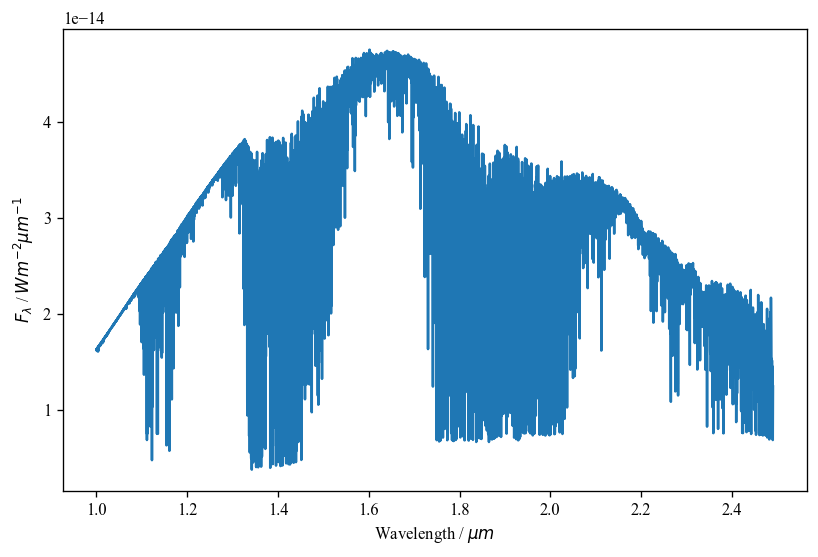

In [13]:
# plot the spectra
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=120,figsize=[8,5])
ax=fig.add_subplot(111)
ax.plot(shiftspec[0,:],shiftspec[1,:])
plt.ylabel(r'$ F_{\lambda}$ / $Wm^{-2} \mu m^{-1}$')
plt.xlabel('Wavelength / $\mu m$')
plt


In [10]:
# from bensconv import conv_non_uniform_R
# modspec = np.array([shiftspec[0,::-1],shiftspec[1,::-1]])
# spec = conv_non_uniform_R(modspec[1, :], modspec[0, :], args_instance.R, obspec[0, :])
